In [142]:
import itertools
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from bokeh.palettes import Category20, Viridis3, Set1
import hdbscan
from xgboost import XGBClassifier
import shap


from DataManager import DataManager
from utils.functions import get_umap_projection
from utils.plotting import plot_rectangles

In [3]:
dm = DataManager()
control_samples = dm.get_control_samples()
percentile = 2
interacting_samples = dm.get_top_interactions(percentile=percentile)

In [4]:
# Calculate UMAP projection
umap_embedding, umap_reducer = get_umap_projection(dm.data.values[:,3:])

# UMAP representation

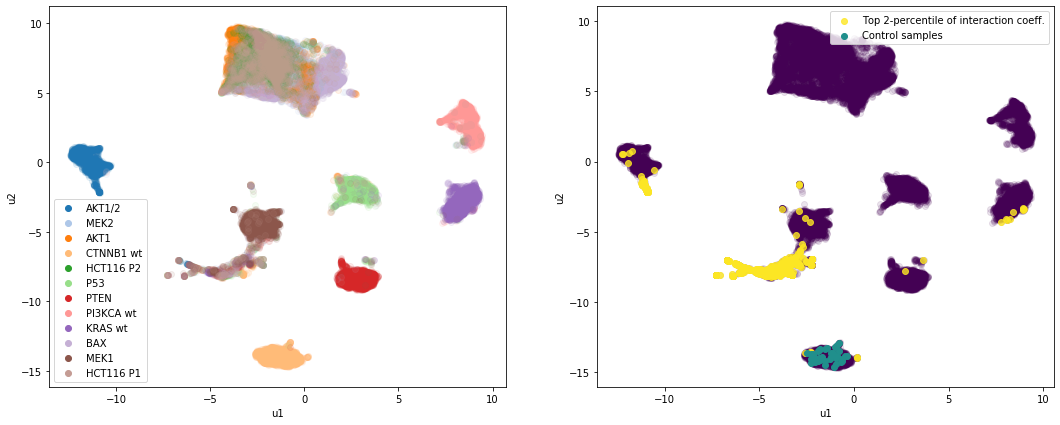

In [5]:
# Plot umap projection with cell line coloring and with
# control samples and strongly interacting samples overlayed

palette1 = Category20
palette2 = Viridis3

fig, ax = plt.subplots(1, 2, figsize=(18,7))

colors = itertools.cycle(palette1[12])    
for cell_line, color in zip(range(12), colors):
    name = dm.cell_line_df["mutation"].iloc[cell_line]
    cl_indexes = dm.data.index[dm.data["cell_line"]==cell_line].tolist()
    ax[0].scatter(umap_embedding[cl_indexes,0], umap_embedding[cl_indexes,1], c=color, alpha=0.09, label=name)

ax[0].set_xlabel("u1")
ax[0].set_ylabel("u2")
leg = ax[0].legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax[1].scatter(umap_embedding[:,0], umap_embedding[:,1], c=palette2[0], alpha=0.1)
ax[1].scatter(umap_embedding[interacting_samples,0], umap_embedding[interacting_samples,1],
              c=palette2[2], alpha=0.8, 
              label = "Top {}-percentile of interaction coeff.".format(percentile))
ax[1].scatter(umap_embedding[control_samples,0], umap_embedding[control_samples,1], c=palette2[1], alpha=1, label="Control samples")

ax[1].set_xlabel("u1")
ax[1].set_ylabel("u2")
ax[1].legend()

#fig.savefig("umap.pdf", bbox_inches = 'tight')
fig.show()

# HDBSCAN clustering

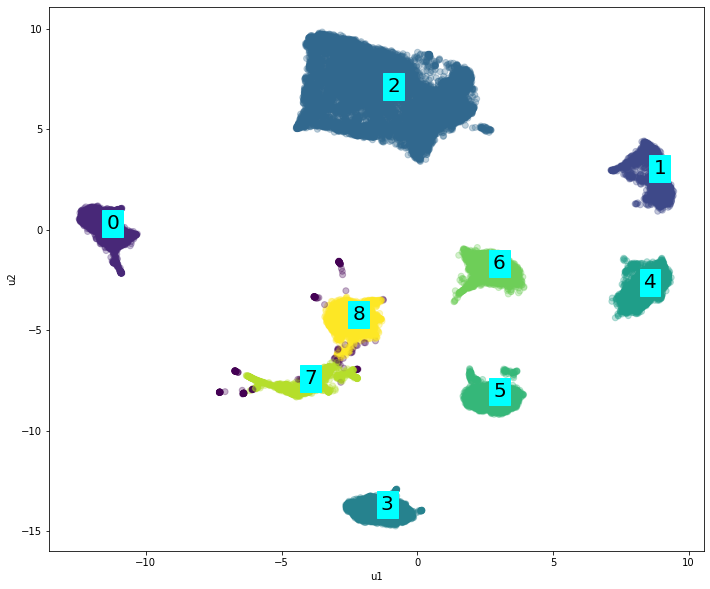

In [6]:
# HDBSCAN
clustering = hdbscan.HDBSCAN(min_cluster_size=60, cluster_selection_epsilon=0.32, min_samples=30).fit(umap_embedding)
labels_set = clustering.labels_

fig, ax = plt.subplots(figsize=(16,10))
sc = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=labels_set, alpha=0.3)#, cmap=plt.get_cmap("Set1"))
#ax.set_title("HDBSCAN clustering of UMAP representation")
ax.set_xlabel("u1")
ax.set_ylabel("u2")


for label in np.unique(labels_set):
    if label < 0:
        continue
    cx = np.mean(umap_embedding[labels_set == label,0])
    cy = np.mean(umap_embedding[labels_set == label,1])
    ax.text(cx, cy, str(label), fontsize=20, backgroundcolor="cyan")
ax.set_aspect(0.7403456297830991)  

#fig.savefig(os.path.join(dm.output_folder, "clustering.pdf"), bbox_inches = 'tight')
 
plt.show()

# Parallel coordinates plots for binary comparison

In [7]:
control_cluster_label = 3
avg_control_ftrs = np.array(dm.data.drop(["cell_line", "drug", "replicate"], axis=1).iloc[control_samples].mean())

In [8]:
def select_most_different_ftrs(ftrs_data_frame, cluster_indexes1, cluster_indexes2, N=20):
    cluster1_avg = ftrs_data_frame.iloc[cluster_indexes1].mean()
    cluster2_avg = ftrs_data_frame.iloc[cluster_indexes2].mean()
    abs_difference = np.abs(cluster1_avg-cluster2_avg)
    sorted_idxs = sorted(range(len(abs_difference)), key=lambda i: abs_difference[i], reverse=True)
    
    ranked_features = [ftrs_data_frame.columns[i] for i in sorted_idxs[:N]]
    ordered_features = []
    selected_ftrs_categories = OrderedDict()
    for category, cat_ftrs in dm.features_categories.items():
        selected_cat_ftrs = sorted([f for f in ranked_features if f in cat_ftrs])
        if len(selected_cat_ftrs)>0:
            ordered_features.extend(selected_cat_ftrs)
            selected_ftrs_categories[category] = len(selected_cat_ftrs)
    return ordered_features, selected_ftrs_categories


def plot_parallel_coords(ax, ftrs_data_frame, cluster_indexes, ftrs_names, categories, 
                         control_features=None, cmap=Category20[20]):
    #col_idxs = ftrs_data_frame.columns.get_loc(ftrs_names)
    ftrs_data = ftrs_data_frame.values
    if control_features is not None:
        ftrs_data = ftrs_data - control_features
    ftrs_data_frame.values[:,:] = ftrs_data
    ftrs_data_frame = ftrs_data_frame[ftrs_names]
    
    all_idxs = np.concatenate([v for v in cluster_indexes.values()])
    max_val = np.amax(np.abs(ftrs_data_frame.iloc[all_idxs].values))
    
    ax.set_ylim(-max_val -0.5, max_val+0.5)
    ax.set_frame_on(False)
    xx = range(len(ftrs_names))
    ax.grid(axis="x")
    ax.hlines(0,xx[0]-0.5,xx[-1]+0.5)
    ax.set_xticks(xx)
    plot_rectangles(ax, categories)
    ax.set_xticklabels(ftrs_names, rotation=45, ha='right')
    
    colors = itertools.cycle(Set1[8])
    for cluster, indexes in cluster_indexes.items():
        cc = next(colors)
        ax.fill_between(xx, ftrs_data_frame.iloc[indexes].min(), 
            ftrs_data_frame.iloc[indexes].max(), color=cc, alpha=0.3)
        ax.plot(xx, ftrs_data_frame.iloc[indexes].mean(),
                          'o-', linewidth=3, color=cc, label="Cluster {}".format(cluster))
    ax.legend()
    
def binary_comparison_pc_clusters(cluster1, cluster2):
    fig, ax = plt.subplots(figsize=(12,8))
    clabels = {}
    for cluster in [cluster1, cluster2]:
        clabels[cluster] = np.where(labels_set==cluster)[0]

    diff_features, diff_ftrs_categories = select_most_different_ftrs(dm.data.drop(["cell_line", "drug", "replicate"], axis=1),
                                                                     clabels[cluster1], clabels[cluster2], N=20)
    plot_parallel_coords(ax, dm.data.drop(["cell_line", "drug", "replicate"], axis=1), clabels, 
                         diff_features, diff_ftrs_categories, 
                         control_features=avg_control_ftrs)
    return fig

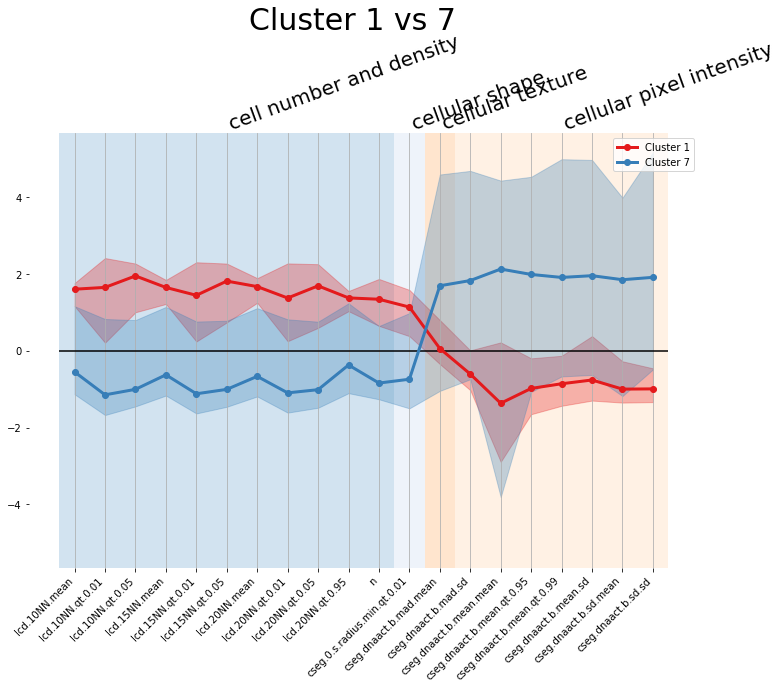

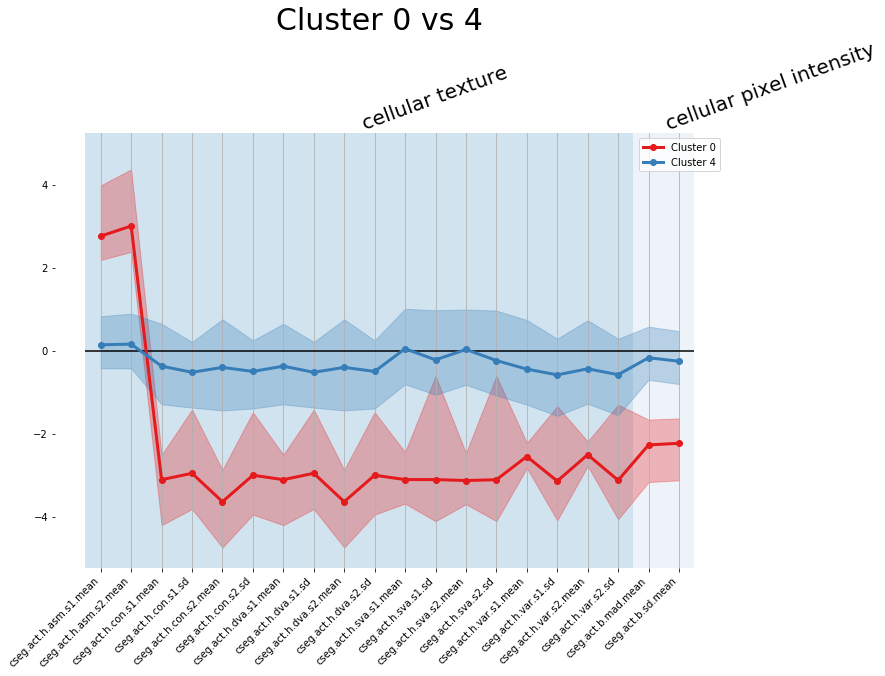

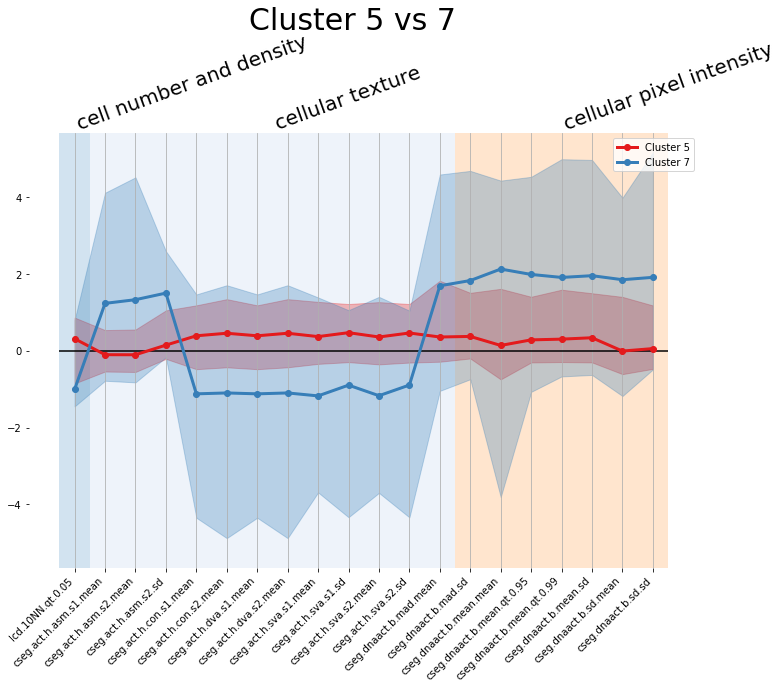

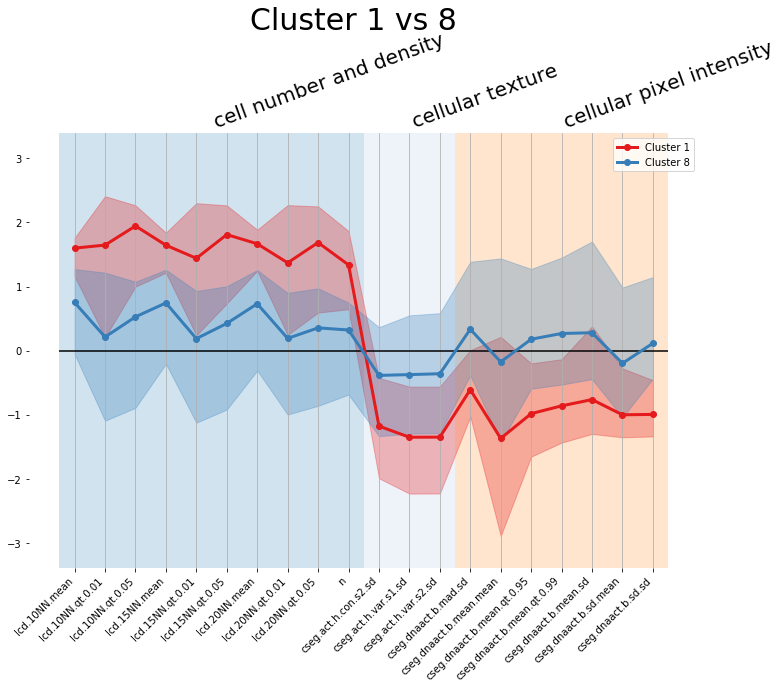

In [9]:
# Randomly selecta pairs of clusters to compare
for i in range(4):
    c1, c2 = np.random.choice([0,1,2,4,5,6,7,8,9], 2, replace=False)
    if c1>c2:
        tmp = c1
        c1 = c2
        c2 = tmp
    fig = binary_comparison_pc_clusters(c1, c2)
    fig.suptitle("Cluster {} vs {}".format(c1, c2), fontsize=30,  y=1.1)

# Classifier feature importance pairwise comparison

In [59]:
def sort_features_by_importance(importances):
    sorted_idxs = sorted(list(range(len(importances))), key=lambda i: importances[i], reverse=True)
    sorted_features = [dm.features[i] for i in sorted_idxs]
    sorted_importances = [importances[i] for i in sorted_idxs]
    return sorted_features, sorted_importances

In [134]:
def pairwise_classifier_comparison(model, cluster1,
                     cluster2,
                     labels,
                     test_split=0.2,
                     shuffle_repetitions = 200):
    

    # Filter data to only consider cluster1 and cluster2
    mask = [l == cluster1 or l == cluster2 for l in labels]
    filtered_labels = LabelEncoder().fit_transform([
        l for l in labels if l == cluster1 or l == cluster2
    ])
    filtered_features = dm.get_feature_values()[mask, :]
    traning_ftrs, test_ftrs, training_cluster_labels, test_cluster_labels = train_test_split(
        filtered_features, filtered_labels, test_size=test_split, random_state=42)
    

    model.fit(traning_ftrs, training_cluster_labels)
    test_accuracy = model.score(test_ftrs, test_cluster_labels)
    
    # SHAP Importances
    explainer = shap.KernelExplainer(model.predict, shap.sample(traning_ftrs, 100)) #CHANGE
    shap_values = explainer.shap_values(test_ftrs, nsamples=100)
    shap_fi = np.sum(np.abs(shap_values), axis=0)
    norm_shap_fi = shap_fi / np.sum(shap_fi) 
#     norm_shap_fi = 0
    
    # Permutation Importances
    print("Computing permutation importance..")
    perm_fi = permutation_importance(model, test_ftrs, test_cluster_labels, 
                                     n_repeats=shuffle_repetitions,
                                random_state=42)['importances_mean']

    summary = {"test_accuracy": test_accuracy, 
                "shap_importances": norm_shap_fi,
                "permutation_importances": perm_fi}
    return summary


In [135]:
# model = LogisticRegression(penalty='l1', solver='liblinear',
#                                        tol=1e-6)
# summ = pairwise_classifier_comparison(model, 0, 7, labels_set,
#                      test_split=0.33, N=5)
# summ

In [136]:
logistic_l1 = LogisticRegression(penalty='l1', solver='liblinear', tol=1e-6, random_state=42)
logistic_l2 = LogisticRegression(penalty='l2', solver='liblinear', tol=1e-6, random_state=42)
#rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

models = [
    (logistic_l1, "Logistic Regression - L1"),
    (logistic_l2, "Logistic Regression - L2"),
    #(rf, "Random Forests"),
    (xgb, "XGBoost")
]

cluster1 = 0
cluster2 = 7
summaries = {}
for model, description in models:
    summ = pairwise_classifier_comparison(model, cluster1, cluster2, labels_set,
                     test_split=0.2, shuffle_repetitions=100)
    summaries[description] = summ


Computing permutation importance..



Computing permutation importance..



Computing permutation importance..


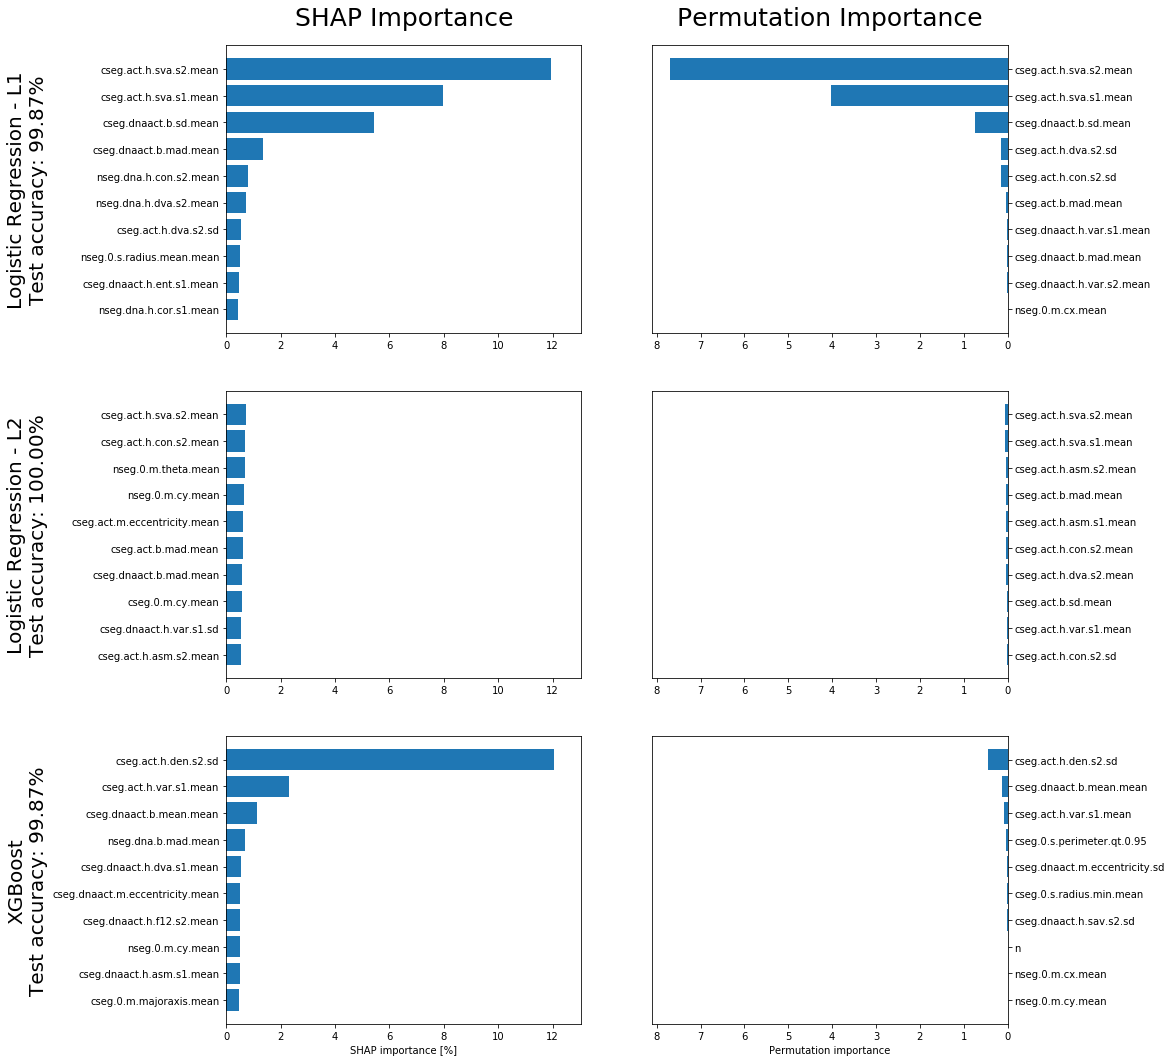

In [182]:
fig, ax = plt.subplots(3, 2, figsize=(14,18))

cols_titles = ["SHAP Importance", "Permutation Importance"]
for axes, col in zip(ax[0], cols_titles):
    axes.set_title(col, fontsize=25, pad=20)

row = 0
n_features = 10

max_shap_fi = max([max(summ["shap_importances"])*100 for m, summ in summaries.items()])
max_perm_fi = max([max(summ["permutation_importances"]) for m, summ in summaries.items()])
for name, summary in summaries.items():
#     ax[row, 0].set_frame_on(False)
#     ax[row, 1].set_frame_on(False)
    ax[row, 0].set_ylabel(name + "\nTest accuracy: {:.2f}%".format(summary["test_accuracy"]*100)
                          , rotation=90, fontsize=20)
    ax[row, 0].set_xlim(0,max_shap_fi+1)
    ax[row, 1].set_xlim(0,8+0.1)
    
    sorted_shap_ftrs, sorted_shap_fi = sort_features_by_importance(summary["shap_importances"])
    sorted_shap_ftrs = sorted_shap_ftrs[:n_features]
    sorted_shap_fi = [fi*100 for fi in sorted_shap_fi[:n_features]]
    shap_y_pos = np.arange(len(sorted_shap_ftrs))
    
    ax[row, 0].barh(shap_y_pos, sorted_shap_fi, align='center')
    ax[row, 0].set_yticks(shap_y_pos)
    ax[row, 0].set_yticklabels(sorted_shap_ftrs)
    ax[row, 0].invert_yaxis()
    
    
    
    sorted_perm_ftrs, sorted_perm_fi = sort_features_by_importance(summary["permutation_importances"])
    sorted_perm_ftrs = sorted_perm_ftrs[:n_features]
    sorted_perm_fi = [fi*100 for fi in sorted_perm_fi[:n_features]]
    perm_y_pos = np.arange(len(sorted_perm_ftrs))

    ax[row, 1].barh(perm_y_pos, sorted_perm_fi, align='center')
    ax[row, 1].set_yticks(perm_y_pos)
    ax[row, 1].set_yticklabels(sorted_perm_ftrs)
    ax[row, 1].invert_yaxis()
    ax[row, 1].invert_xaxis()
    ax[row, 1].yaxis.tick_right()
    
    row += 1
    
ax[-1, 0].set_xlabel('SHAP importance [%]')
ax[-1, 1].set_xlabel('Permutation importance')

fig.align_ylabels(ax[:, 0])
fig.savefig(os.path.join(dm.output_folder, "pairwise_importances.pdf"), bbox_inches = "tight")
plt.show()

